In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

import cv2
import tensorflow as tf
from keras.preprocessing.image import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input

In [ ]:
from tensorflow.keras.models import load_model

model = load_model('/content/drive/My Drive/Comp Vis Final Proj/alexis_vers/mymodel.h5')

In [ ]:
X = np.load('/content/drive/My Drive/Comp Vis Final Proj/alexis_vers/X.npy')

In [ ]:
gender_dict = {0:'Male', 1:'Female'}
race_dict = {0:'White', 1:'Black', 2:'Asian', 3:'Indian', 4:'Other'}

In [ ]:
data = "/content/drive/My Drive/Comp Vis Final Proj/UTKFace"

In [ ]:
image_paths = []
age_labels = []
gender_labels = []
race_labels = []

for filename in tqdm(os.listdir(data)):
    image_path = os.path.join(data, filename)
    try:
        temp = filename.split('_')
        age = int(temp[0])
        gender = int(temp[1])
        race = int(temp[2])
    except ValueError:
        print("Skipping file:", filename)
        continue
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)
    race_labels.append(race)

  0%|          | 0/9821 [00:00<?, ?it/s]

Skipping file: rename.bash
Skipping file: 61_1_20170109142408075.jpg


In [ ]:
df = pd.DataFrame()
df['image'], df['age'], df['gender'], df['race'] = image_paths, age_labels, gender_labels, race_labels
df.head()

,image,age,gender,race
0,/content/drive/My Drive/Comp Vis Final Proj/UT...,67,0,1
1,/content/drive/My Drive/Comp Vis Final Proj/UT...,63,0,1
2,/content/drive/My Drive/Comp Vis Final Proj/UT...,66,0,0
3,/content/drive/My Drive/Comp Vis Final Proj/UT...,65,0,1
4,/content/drive/My Drive/Comp Vis Final Proj/UT...,6,0,0


In [ ]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])
y_race = np.array(df['race'])

Original Gender: Male Original Age: 70
1/1 [==============================] - 0s 305ms/step
Predicted Gender: Male Predicted Age: 75


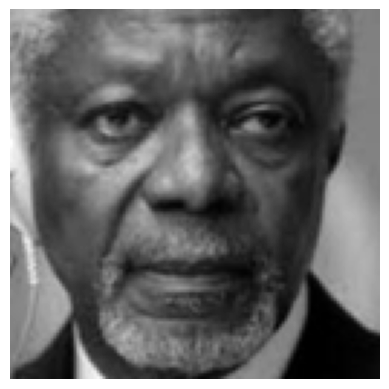

In [ ]:
image_index = 103
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

4201
4201
4201
Race: White
Number of samples: 4201


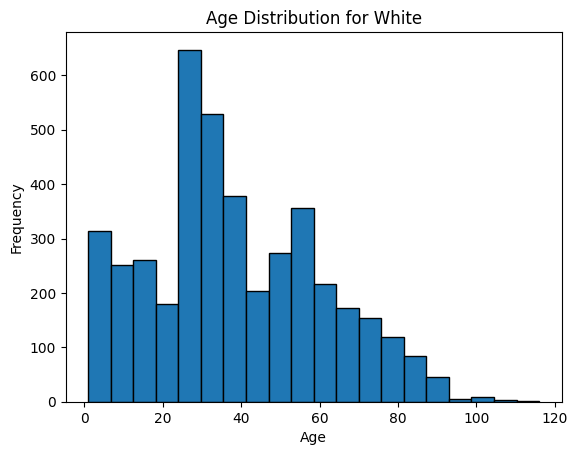

1863
1863
1863
Race: Black
Number of samples: 1863


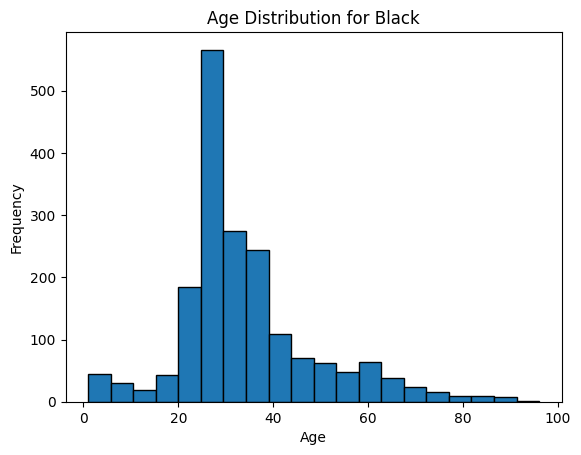

1392
1392
1392
Race: Asian
Number of samples: 1392


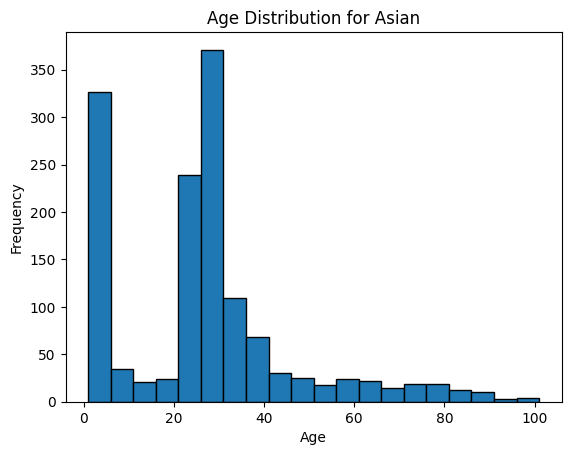

1642
1642
1642
Race: Indian
Number of samples: 1642


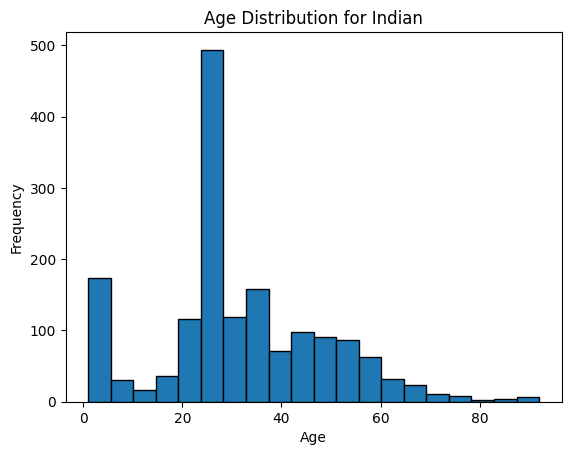

721
721
721
Race: Other
Number of samples: 721


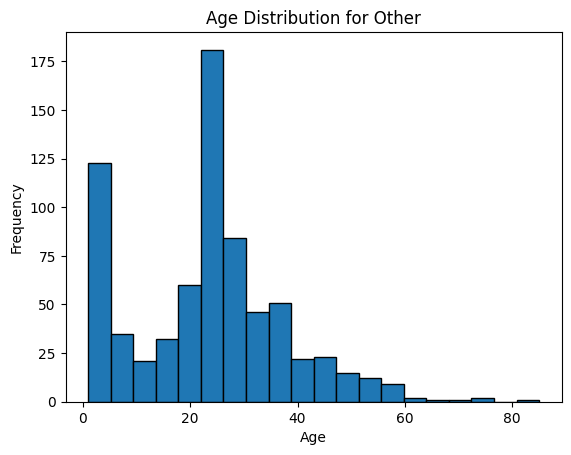

In [ ]:
from sklearn.model_selection import train_test_split

# Dictionary to store datasets for each race
datasets_per_race = {}

# Split the dataset based on race
unique_races = np.unique(y_race)
for race in race_dict:
    race_indices = np.where(y_race == race)[0]
    X_race = X[race_indices]
    y_age_race = y_age[race_indices]
    y_gender_race = y_gender[race_indices]
    print(len(X_race))
    print(len(y_age_race))
    print(len(y_gender_race))
    # Split the race dataset into train and test sets
    # X_train, X_test, y_train, y_test = train_test_split(X_race, y_age_race, test_size=0.2, random_state=42)

    print(f"Race: {race_dict[race]}")
    print(f"Number of samples: {len(X_race)}")

    # Plot the age distribution for each race
    plt.figure()
    plt.hist(y_age_race, bins=20, edgecolor='black')
    plt.title(f"Age Distribution for {race_dict[race]}")
    plt.xlabel("Age")
    plt.ylabel("Frequency")
    plt.show()


    datasets_per_race[race_dict[race]] = {'X': X_race, 'y': y_age_race, 'gender': y_gender_race}

## failed experiments

In [ ]:
print(datasets_per_race['Asian']['X'].shape)

(1392, 128, 128, 1)


In [ ]:
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# Define a function to balance the datasets (by age) for each race
def balance_datasets_per_race(datasets_per_race):
    # Get the age distribution of the white race group (race == 0)
    white_race_age_distribution = Counter(datasets_per_race['White']['y'])

    # Iterate over each race group
    for race, data in datasets_per_race.items():
        X_race = data['X']
        y_age_race = data['y']

        # Check if the current race group is not the white race group
        if race != 'White':
            # Flatten the spatial dimensions of X_race into a single dimension
            num_samples = X_race.shape[0]
            X_race_flat = X_race.reshape(num_samples, -1)

            # Get the age distribution of the current race group
            race_age_distribution = Counter(y_age_race)

            # Calculate the oversampling/undersampling ratio
            oversample_ratio = {
                age: white_race_age_distribution[age] / race_age_distribution.get(age, 1)
                for age in set(white_race_age_distribution.keys()) & set(race_age_distribution.keys())
            }

            # Perform random oversampling or undersampling to balance the age distribution
            if max(oversample_ratio.values()) > 1:
                ros = RandomOverSampler(sampling_strategy=oversample_ratio, random_state=42)
                X_resampled_flat, y_resampled = ros.fit_resample(X_race_flat, y_age_race)
            else:
                rus = RandomUnderSampler(sampling_strategy=oversample_ratio, random_state=42)
                X_resampled_flat, y_resampled = rus.fit_resample(X_race_flat, y_age_race)

            # Reshape X_resampled_flat back to its original shape
            X_resampled = X_resampled_flat.reshape(-1, *X_race.shape[1:])

            # Update the datasets_per_race dictionary with the balanced dataset
            datasets_per_race[race] = {'X': X_resampled, 'y': y_resampled}

    return datasets_per_race

# Call the function to balance the datasets (by age) for each race
balanced_datasets_per_race = balance_datasets_per_race(datasets_per_race)


ValueError: With over-sampling methods, the number of samples in a class should be greater or equal to the original number of samples. Originally, there is 15 samples and 9.466666666666667 samples are asked.

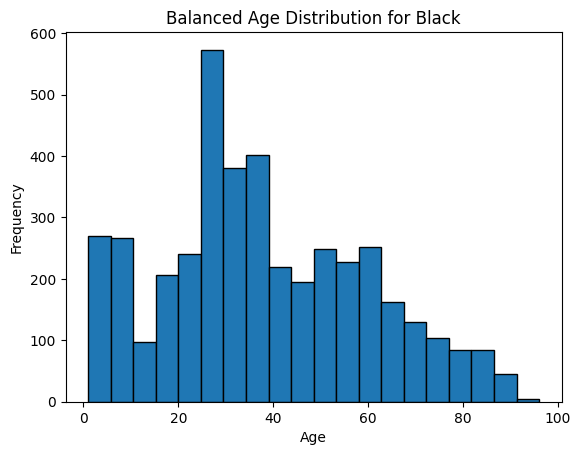

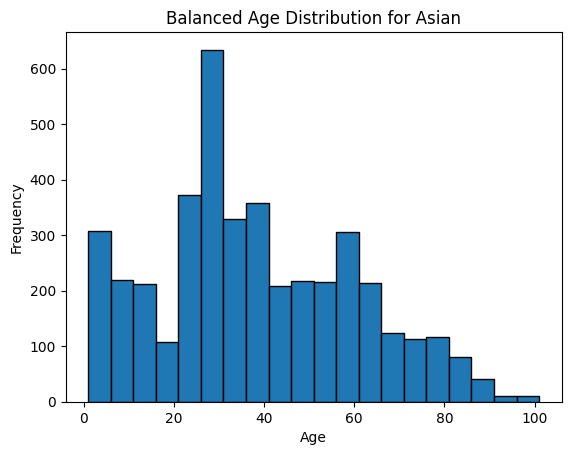

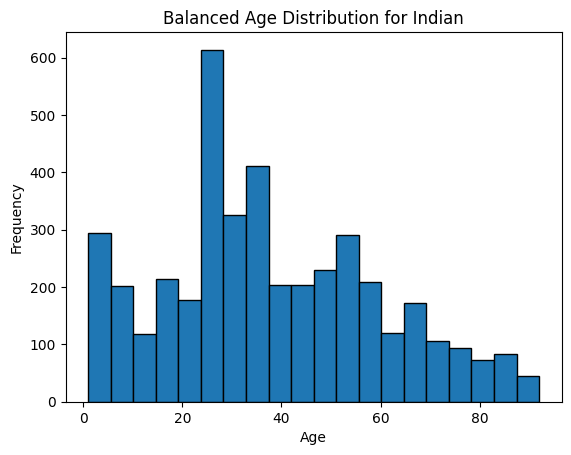

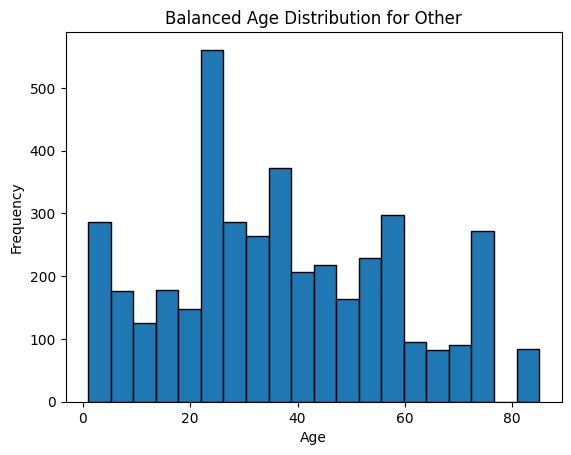

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import resample

# Calculate histogram of age distribution for the white group
white_age_hist, white_age_bins = np.histogram(datasets_per_race['White']['y'], bins=20)

# Balancing datasets for each race
for race in datasets_per_race:
    if race != 'White':
        race_data = datasets_per_race[race]['y']
        # Calculate histogram of age distribution for the current race
        race_age_hist, race_age_bins = np.histogram(race_data, bins=20)
        # Resample the race data to match the age distribution of the white group
        resampled_race_data = []
        for i, count in enumerate(white_age_hist):
            if count == 0:
                continue
            age_range_indices = np.where((race_data >= white_age_bins[i]) & (race_data < white_age_bins[i + 1]))[0]
            # Check if age_range_indices is empty
            if len(age_range_indices) == 0:
                continue
            resampled_age_range_indices = np.random.choice(age_range_indices, size=count, replace=True)
            resampled_race_data.extend(race_data[resampled_age_range_indices])
        # Update the dataset with the balanced data
        datasets_per_race[race]['y'] = np.array(resampled_race_data)

        # Plot the balanced age distribution
        plt.figure()
        plt.hist(datasets_per_race[race]['y'], bins=20, edgecolor='black')
        plt.title(f"Balanced Age Distribution for {race}")
        plt.xlabel("Age")
        plt.ylabel("Frequency")
        plt.show()



In [ ]:
print(len(datasets_per_race['White']['X']))
print(len(datasets_per_race['Black']['X']))
print(len(datasets_per_race['Asian']['X']))
print(len(datasets_per_race['Indian']['X']))
print(len(datasets_per_race['Other']['X']))

4201
1863
1392
1642
721


In [ ]:
print(len(datasets_per_race['White']['y']))
print(len(datasets_per_race['Black']['y']))
print(len(datasets_per_race['Asian']['y']))
print(len(datasets_per_race['Indian']['y']))
print(len(datasets_per_race['Other']['y']))

4201
4189
4197
4184
4139


In [ ]:
import pandas as pd

# Create empty lists to store combined data
image_paths_combined = []
age_labels_combined = []
gender_labels_combined = []
race_labels_combined = []

# Iterate through each race group in datasets_per_race
for race, data in datasets_per_race.items():
    # Append data from each race group to combined lists
    image_paths_combined.extend(data['X'])
    age_labels_combined.extend(data['y'])
    # Assuming you have gender_labels and race_labels available, you can append them as well
    gender_labels_combined.extend(gender_labels)  # Replace gender_labels with your actual gender labels
    race_labels_combined.extend([race] * len(data['X']))
print(len(image_paths_combined))
print(len(age_labels_combined))
print(len(gender_labels_combined))
print(len(race_labels_combined))



# Create DataFrame
df_balanced = pd.DataFrame({
    'image': image_paths_combined,
    'age': age_labels_combined,
    'gender': gender_labels_combined,
    'race': race_labels_combined
})

# Display the first few rows of the DataFrame
print(df_balanced.head())


9819
20910
49095
9819


ValueError: All arrays must be of the same length

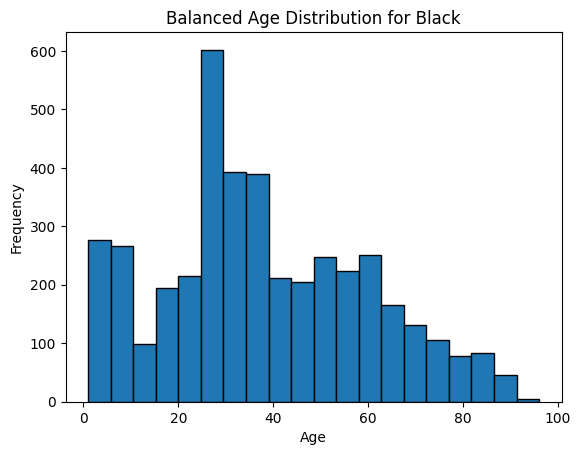

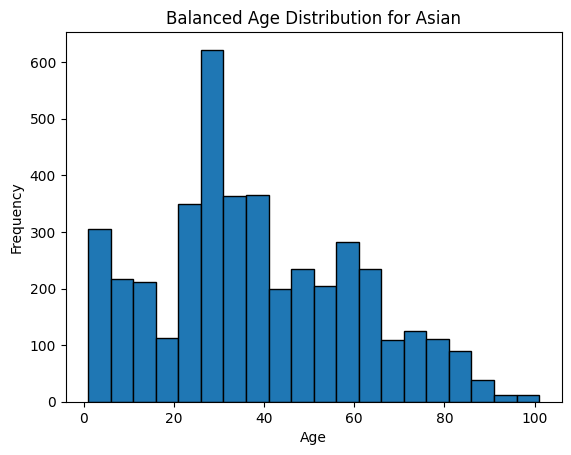

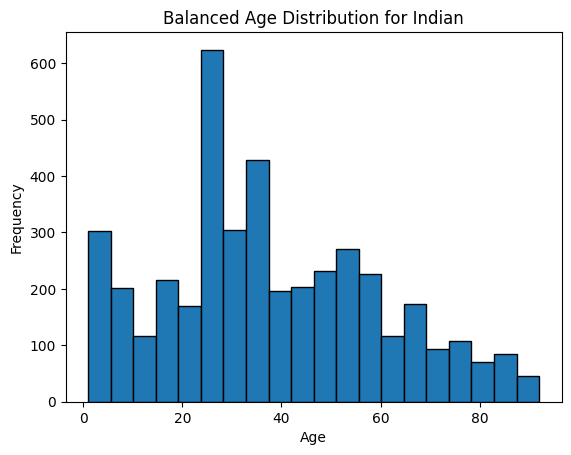

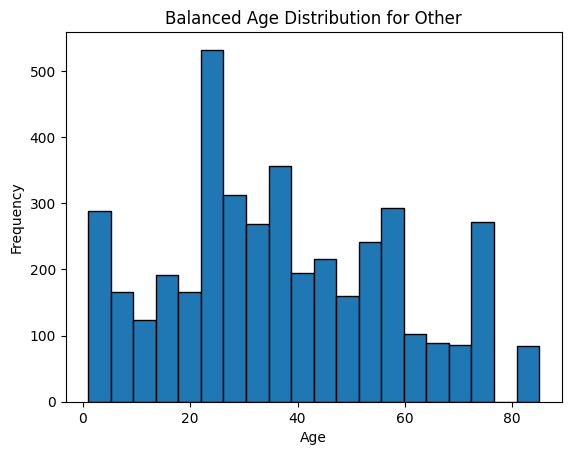

16709
16709
16709
16709


ValueError: Length of values (4139) does not match length of index (16709)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import resample

# Define race labels mapping
race_mapping = {'White': 0, 'Black': 1, 'Asian': 2, 'Indian': 3, 'Other': 4}

# Initialize lists to store combined data
image_paths = []
age_labels = []
gender_labels = []
race_labels = []

# Calculate histogram of age distribution for the white group
white_age_hist, white_age_bins = np.histogram(datasets_per_race['White']['y'], bins=20)

# Balancing datasets for each race
for race, data in datasets_per_race.items():
    if race != 'White':
        race_data = data['y']
        # Calculate histogram of age distribution for the current race
        race_age_hist, race_age_bins = np.histogram(race_data, bins=20)
        # Resample the race data to match the age distribution of the white group
        resampled_race_data = []
        for i, count in enumerate(white_age_hist):
            if count == 0:
                continue
            age_range_indices = np.where((race_data >= white_age_bins[i]) & (race_data < white_age_bins[i + 1]))[0]
            # Check if age_range_indices is empty
            if len(age_range_indices) == 0:
                continue
            resampled_age_range_indices = np.random.choice(age_range_indices, size=count, replace=True)
            resampled_race_data.extend(race_data[resampled_age_range_indices])
            # Sample corresponding images
            resampled_images = data['X'][resampled_age_range_indices]
            image_paths.extend(resampled_images)
            # Sample corresponding genders
            resampled_ages = data['y'][resampled_age_range_indices]
            age_labels.extend(resampled_ages)
            resampled_genders = data['gender'][resampled_age_range_indices]
            gender_labels.extend(resampled_genders)
            # Sample corresponding race labels
            resampled_races = [race_mapping[race]] * count
            race_labels.extend(resampled_races)

        # Plot the balanced age distribution
        plt.figure()
        plt.hist(resampled_race_data, bins=20, edgecolor='black')
        plt.title(f"Balanced Age Distribution for {race}")
        plt.xlabel("Age")
        plt.ylabel("Frequency")
        plt.show()
print(len(image_paths))
print(len(age_labels))
print(len(gender_labels))
print(len(race_labels))
# Create DataFrame
df_balanced = pd.DataFrame()
df_balanced['image'] = image_paths
df_balanced['age'] = resampled_race_data
df_balanced['gender'] = gender_labels
df_balanced['race'] = race_labels

# Display the first few rows of the DataFrame
print(df.head())


## current experiments

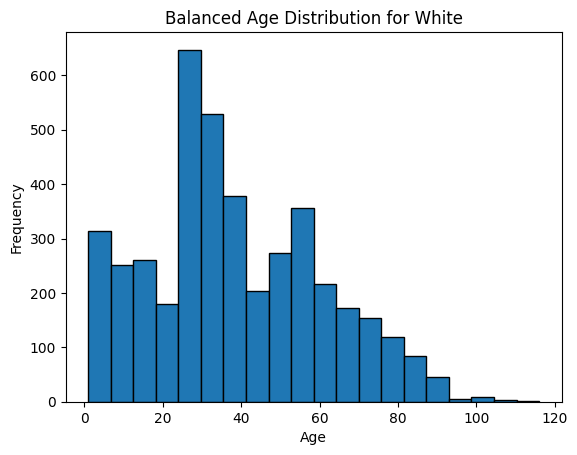

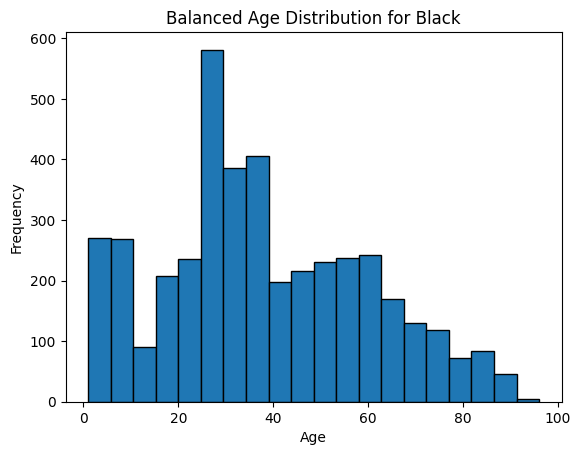

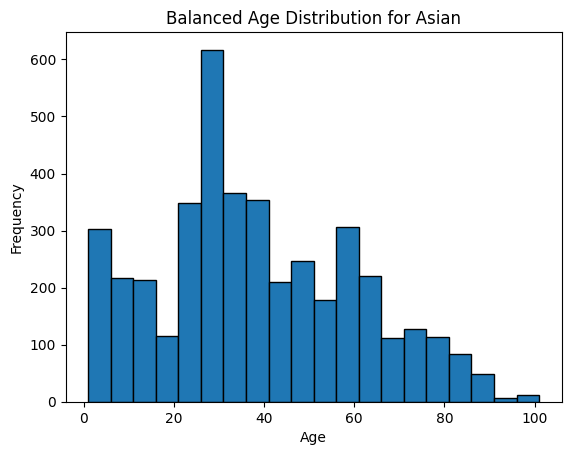

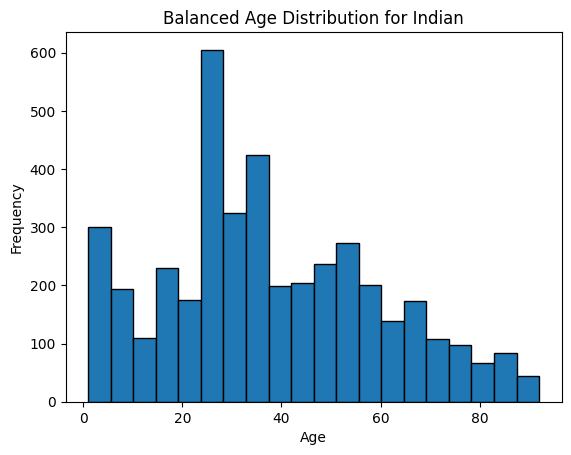

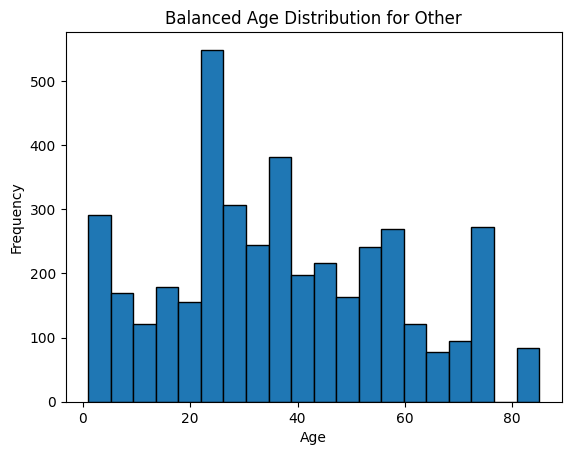

(20910, 128, 128, 1)
   age  gender  race
0   66       0     0
1    6       0     0
2   63       0     0
3   65       0     0
4   64       1     0


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import resample

# Define race labels mapping
race_mapping = {'White': 0, 'Black': 1, 'Asian': 2, 'Indian': 3, 'Other': 4}

# Initialize lists to store combined data
image_paths = []
age_labels = []
gender_labels = []
race_labels = []

# Calculate histogram of age distribution for the white group
white_age_hist, white_age_bins = np.histogram(datasets_per_race['White']['y'], bins=20)

# Balancing datasets for each race
for race, data in datasets_per_race.items():
    if race != 'White':
        race_data = data['y']
        # Calculate histogram of age distribution for the current race
        race_age_hist, race_age_bins = np.histogram(race_data, bins=20)
        # Resample the race data to match the age distribution of the white group
        resampled_race_data = []
        for i, count in enumerate(white_age_hist):
            if count == 0:
                continue
            age_range_indices = np.where((race_data >= white_age_bins[i]) & (race_data < white_age_bins[i + 1]))[0]
            # Check if age_range_indices is empty
            if len(age_range_indices) == 0:
                continue
            resampled_age_range_indices = np.random.choice(age_range_indices, size=count, replace=True)
            resampled_race_data.extend(race_data[resampled_age_range_indices])
            # Sample corresponding images
            resampled_images = data['X'][resampled_age_range_indices]
            image_paths.extend(resampled_images)
            # Sample corresponding genders
            resampled_genders = data['gender'][resampled_age_range_indices]
            gender_labels.extend(resampled_genders)
            # Sample corresponding ages
            resampled_ages = data['y'][resampled_age_range_indices]
            age_labels.extend(resampled_ages)
            # Sample corresponding race labels
            resampled_races = [race_mapping[race]] * count
            race_labels.extend(resampled_races)

    else:
        race_data = data['y']
        resampled_race_data = []
        resampled_race_data.extend(race_data)
        image_paths.extend(data['X'])
        gender_labels.extend(data['gender'])
        age_labels.extend(data['y'])
        race_labels.extend([race_mapping['White']] * len(data['y']))


    # Plot the balanced age distribution
    plt.figure()
    plt.hist(resampled_race_data, bins=20, edgecolor='black')
    plt.title(f"Balanced Age Distribution for {race}")
    plt.xlabel("Age")
    plt.ylabel("Frequency")
    plt.show()

# Convert lists to NumPy arrays
image_paths = np.array(image_paths)
age_labels = np.array(age_labels)
gender_labels = np.array(gender_labels)
race_labels = np.array(race_labels)

# Create DataFrame
df_balanced = pd.DataFrame()
print (image_paths.shape)
# df_balanced['image'] = image_paths
df_balanced['age'] = age_labels
df_balanced['gender'] = gender_labels
df_balanced['race'] = race_labels

# Display the first few rows of the DataFrame
print(df_balanced.head())


In [ ]:
print(df.head)

<bound method NDFrame.head of                                                   image  age  gender  race
0     /content/drive/My Drive/Comp Vis Final Proj/UT...   67       0     1
1     /content/drive/My Drive/Comp Vis Final Proj/UT...   63       0     1
2     /content/drive/My Drive/Comp Vis Final Proj/UT...   66       0     0
3     /content/drive/My Drive/Comp Vis Final Proj/UT...   65       0     1
4     /content/drive/My Drive/Comp Vis Final Proj/UT...    6       0     0
...                                                 ...  ...     ...   ...
9814  /content/drive/My Drive/Comp Vis Final Proj/UT...    1       0     4
9815  /content/drive/My Drive/Comp Vis Final Proj/UT...    1       1     0
9816  /content/drive/My Drive/Comp Vis Final Proj/UT...    1       0     2
9817  /content/drive/My Drive/Comp Vis Final Proj/UT...    1       1     3
9818  /content/drive/My Drive/Comp Vis Final Proj/UT...   20       0     0

[9819 rows x 4 columns]>


In [ ]:
df_balanced.to_csv('/content/drive/My Drive/Comp Vis Final Proj/alexis_vers/balanced_data_noimages_withwhite.csv', index=False)

In [ ]:
np.save('/content/drive/My Drive/Comp Vis Final Proj/alexis_vers/X_balanced_withwhite.npy', image_paths)

In [ ]:
y_gender_balanced = np.array(df_balanced['gender'])
y_age_balanced = np.array(df_balanced['age'])
y_race_balanced = np.array(df_balanced['race'])

In [ ]:
input_shape = (128,128,1)

In [ ]:
inputs = Input((input_shape))

conv_1 = Conv2D(32, kernel_size=(3,3), activation='relu')(inputs)
maxp_1 = MaxPooling2D(pool_size=(2,2))(conv_1)

conv_2 = Conv2D(32, kernel_size=(3,3), activation='relu')(maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2,2))(conv_2)

conv_3 = Conv2D(32, kernel_size=(3,3), activation='relu')(maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2,2))(conv_3)

conv_4 = Conv2D(32, kernel_size=(3,3), activation='relu')(maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2,2))(conv_4)

flatten = Flatten()(maxp_4)

# Fully connected layers
dense_1 = Dense(256, activation = 'relu')(flatten)
dense_2 = Dense(256, activation = 'relu')(flatten)
# dense_3 = Dense(256, activation = 'relu')(flatten)

dropout_1 = Dropout(0.3)(dense_1)
dropout_2 = Dropout(0.3)(dense_2)
# dropout_3 = Dropout(0.3)(dense_3)

output_1 = Dense(1, activation = 'sigmoid', name = 'gender_out')(dropout_1)
output_2 = Dense(1, activation = 'relu', name = 'age_out')(dropout_2)
# output_3 = Dense(1, activation = 'relu', name = 'race_out')(dropout_3)

# model = Model(inputs = [inputs], outputs = [output_1, output_2, output_3])
model = Model(inputs = [inputs], outputs = [output_1, output_2])

model.compile(loss = ['binary_crossentropy', 'mae'], optimizer = 'adam', metrics = ['accuracy','mae'])

In [ ]:
print(type(X))
print(type(df_balanced['image']))
X_balanced = df_balanced['image'].values
print(type(X_balanced))
print(X.shape)
print(df_balanced['image'].shape)
print(X_balanced.shape)
# X_balanced = X_balanced.reshape(len(X_balanced), 128, 128, 1)
# print(X_balanced.shape)
print(X[:1])
print(X_balanced[:1])


<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>
(9819, 128, 128, 1)
(16709,)
(16709,)
[[[[0.4       ]
   [0.54117647]
   [0.60784314]
   ...
   [0.22745098]
   [0.20784314]
   [0.16470588]]

  [[0.38823529]
   [0.52941176]
   [0.59607843]
   ...
   [0.23921569]
   [0.21960784]
   [0.17254902]]

  [[0.36078431]
   [0.48627451]
   [0.56862745]
   ...
   [0.25882353]
   [0.24313725]
   [0.19607843]]

  ...

  [[0.98823529]
   [0.98823529]
   [0.98823529]
   ...
   [0.6627451 ]
   [0.67843137]
   [0.68627451]]

  [[0.98823529]
   [0.98823529]
   [0.98823529]
   ...
   [0.66666667]
   [0.68235294]
   [0.68627451]]

  [[0.98823529]
   [0.98823529]
   [0.98823529]
   ...
   [0.66666667]
   [0.68627451]
   [0.68627451]]]]
[array([[[0.15294118],
         [0.17647059],
         [0.2       ],
         ...,
         [0.50980392],
         [0.55294118],
         [0.6627451 ]],

        [[0.21568627],
         [0.17647059],
         [0.17647059],
         ...,
   

In [ ]:
print(type(image_paths))

<class 'numpy.ndarray'>


In [ ]:
history = model.fit(x = image_paths, y = [y_gender_balanced, y_age_balanced], batch_size=32, epochs = 30, validation_split = 0.2)

Epoch 1/30
418/418 [==============================] - 269s 638ms/step - loss: 18.9833 - gender_out_loss: 0.6792 - age_out_loss: 18.3040 - gender_out_accuracy: 0.5855 - gender_out_mae: 0.4753 - age_out_accuracy: 0.0394 - age_out_mae: 18.3040 - val_loss: 17.6228 - val_gender_out_loss: 0.5776 - val_age_out_loss: 17.0453 - val_gender_out_accuracy: 0.7319 - val_gender_out_mae: 0.4263 - val_age_out_accuracy: 0.0000e+00 - val_age_out_mae: 17.0453
Epoch 2/30
418/418 [==============================] - 257s 615ms/step - loss: 14.2450 - gender_out_loss: 0.5376 - age_out_loss: 13.7074 - gender_out_accuracy: 0.7388 - gender_out_mae: 0.3536 - age_out_accuracy: 0.0365 - age_out_mae: 13.7074 - val_loss: 11.5192 - val_gender_out_loss: 0.4127 - val_age_out_loss: 11.1065 - val_gender_out_accuracy: 0.8256 - val_gender_out_mae: 0.2817 - val_age_out_accuracy: 0.0000e+00 - val_age_out_mae: 11.1065
Epoch 3/30
418/418 [==============================] - 269s 645ms/step - loss: 12.3941 - gender_out_loss: 0.4782 

KeyboardInterrupt: 